## **Primer versión del EDA**

**Objetivo:**
* Realizar tareas de EDA y limpieza de datos, eliminando valores nulos, inconsistentes, vacios, outliers, inválidos, etc. Proporcionamos también una versión no modificada (limpia) del dataset original, para que comparen sus resultados. (Pueden documentar métricas utilizadas, etc.)

* Realizar transformaciones necesarias para preparar los datos para el análisis y modelado.

* Realizar análisis exploratorio de datos utilizando visualizaciones y estadísticas descriptivas.

* Aplicar técnicas de preprocesamiento como normalización, codificación de variables categóricas y reducción de dimensionalidad, etc.


*PENDIENTE:*

* CONVERTIR ALGUNAS CELDAS EN FUNCIONES
* SABER QUÉ HACER CON LA COLUMNA *mixed_type_col*
* REVISIÓN DE HIPERPARAMETROS


# **1. Carga de paqueterías**

In [1]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deep_translator import GoogleTranslator
import seaborn as sns
import xgboost
from io import StringIO

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import fbeta_score, make_scorer, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Modelos de Claisficación:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.metrics import geometric_mean_score
import requests



# **2. Carga de datos**

In [2]:
# Path local relativo a la ubicación del notebook en el proyecto.
path = "../../data/raw/german_credit_modified.csv"

data_original = pd.read_csv(path)
print(data_original.shape)

(1020, 22)


In [3]:
# Path local relativo a la ubicación del notebook en el proyecto.
path_2 = "../../data/raw/german_credit_original.csv"

data_sin_modificar = pd.read_csv(path_2)
data_sin_modificar.describe()
print(data_sin_modificar.shape)

(1000, 21)


In [4]:
data_sin_modificar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   laufkont  1000 non-null   int64
 1   laufzeit  1000 non-null   int64
 2   moral     1000 non-null   int64
 3   verw      1000 non-null   int64
 4   hoehe     1000 non-null   int64
 5   sparkont  1000 non-null   int64
 6   beszeit   1000 non-null   int64
 7   rate      1000 non-null   int64
 8   famges    1000 non-null   int64
 9   buerge    1000 non-null   int64
 10  wohnzeit  1000 non-null   int64
 11  verm      1000 non-null   int64
 12  alter     1000 non-null   int64
 13  weitkred  1000 non-null   int64
 14  wohn      1000 non-null   int64
 15  bishkred  1000 non-null   int64
 16  beruf     1000 non-null   int64
 17  pers      1000 non-null   int64
 18  telef     1000 non-null   int64
 19  gastarb   1000 non-null   int64
 20  kredit    1000 non-null   int64
dtypes: int64(21)
memory usage: 164.2 KB


# **3. EDA**

**`NOTA AL EQUIPO`** Inicialmente puse éste pedazo para cambiar los títulos a inglés y hacerlo más entendible, pero como la BD original está en alemán, la dejé así. Igual estaría chido cambiarlo. ¿Cómo ven?

In [5]:
# Éste código al final no lo corro, porque los datos originales vienen en aleman.

print('-----Impresión de datos originales ------')
display(data_original.head())

## Lo primero que notamos es que tenemos los encabezados en alemán. para facilitar la manipulación, haré la traducción de los encabezados.

print('-----Inicializar el traductor ... ------')
# Especificamos el idioma de origen ('de' para alemán) y el de destino ('en' para inglés).
translator = GoogleTranslator(source='de', target='en')

# Obtenemos los encabezados y los traducimos.
encabezados_alemanes = data_original.columns.tolist()

## Traducción de los encabezados
encabezados_ingleses = [translator.translate(col) for col in data_original.columns]


data = data_original.copy()
# data.columns = encabezados_ingleses <- en éste pedazo traduzco el encabezado, pero en el DF original lo dejan así, entonces no lo moveré por el momento

print('-----Impresión de datos modificados ------')
display(data.head())

-----Impresión de datos originales ------


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,bad
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,unknown
3,1.0,12.0,4.0,0.0,2122.0,1.0,3.0,3.0,3.0,1.0,...,39.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN
4,1.0,12.0,4.0,0.0,2171.0,1.0,3.0,4.0,3.0,NaN,...,38.0,1.0,2.0,2.0,2.0,error,1.0,1.0,1.0,208


-----Inicializar el traductor ... ------
-----Impresión de datos modificados ------


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,bad
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,unknown
3,1.0,12.0,4.0,0.0,2122.0,1.0,3.0,3.0,3.0,1.0,...,39.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN
4,1.0,12.0,4.0,0.0,2171.0,1.0,3.0,4.0,3.0,NaN,...,38.0,1.0,2.0,2.0,2.0,error,1.0,1.0,1.0,208


In [6]:
print('--- Descripción de las variables iniciales ---')

print(f'Dimensiones de la base: {data.shape}')

## 22 variables numéricas.
data.info()

## Si bien sabemos, por las descripciones de la base, que estamos
data['mixed_type_col'].value_counts()

--- Descripción de las variables iniciales ---
Dimensiones de la base: (1020, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   laufkont        1005 non-null   object
 1   laufzeit        1010 non-null   object
 2   moral           1003 non-null   object
 3   verw            1004 non-null   object
 4   hoehe           1012 non-null   object
 5   sparkont        1008 non-null   object
 6   beszeit         1003 non-null   object
 7   rate            1011 non-null   object
 8   famges          1013 non-null   object
 9   buerge          1007 non-null   object
 10  wohnzeit        1005 non-null   object
 11  verm            1009 non-null   object
 12  alter           1009 non-null   object
 13  weitkred        1010 non-null   object
 14  wohn            1015 non-null   object
 15  bishkred        1008 non-null   object
 16  beruf         

mixed_type_col
unknown    112
bad         98
659          5
1            4
201          4
          ... 
396          1
675          1
549          1
400          1
11           1
Name: count, Length: 500, dtype: int64

In [7]:
##-------------- DEFINICIÓN DE LOS DIFERENTES TIPOS DE VARIABLES --------------------

# Variables numéricas:
lista_paper_num = ['laufzeit', # (duration - quantitative)
              'hoehe', # (amount - quantitative)
              'alter' # (age - quantitative)
              ]

# Variables ordinales:
lista_paper_ord = ['beszeit', # (employment_duration - ordinal)
              'rate', # (installment_rate - ordinal)
              'wohnzeit', # (present_residence - ordinal)
              'verm', # (property - ordinal)
              'bishkred', # (number_credits - ordinal)
              'beruf' # (job - ordinal)
              ]

# Variables nominales & binarias:
lista_paper_cat = [ 'laufkont', # (status - categorical)
              'moral', # (credit_history - categorical)
              'verw', # (purpose - categorical)
              'sparkont', # (savings - categorical)
              'famges', # (personal_status_sex - categorical)
              'buerge', # (other_debtors - categorical)
              'weitkred', # (other_installment_plans - categorical)
              'wohn', # (housing - categorical)
              'pers', # (people_liable - binary)
              'telef', # (telephone - binary)
              'gastarb' # (foreign_worker - binary)
              ]

print("Para los datos de entrada, veamos la cantidad de cada tipo de variable obtenida:")
print("Variables numéricas:", len(lista_paper_num))
print("Variables ordinales:", len(lista_paper_ord))
print("Variables nominales & binarias:", len(lista_paper_cat))

Para los datos de entrada, veamos la cantidad de cada tipo de variable obtenida:
Variables numéricas: 3
Variables ordinales: 6
Variables nominales & binarias: 11


### **3.1** Detección de valores no válidos y conversión de variables numéricas.

In [8]:
## Conversión de las variables a variables numéricas
# PENDIENTE: PASAR ESTO A UNA FUNCION

## Exploratorio del tipo de variables que tenemos dentro del DataFrame

non_numeric_summary = {}

for col in data.columns:
    temp_numeric = pd.to_numeric(data[col], errors='coerce')
    non_numeric_elements = temp_numeric.isna()

    if non_numeric_elements.any():
        non_numeric_values = data[col][non_numeric_elements]
        non_numeric_summary[col] = non_numeric_values.value_counts().to_dict() #unique().tolist()

non_numeric_df = pd.Series(non_numeric_summary)

## Convertir el diccionario resultante en una Serie de pandas para una visualización clara
non_numeric_series = pd.Series(non_numeric_summary)
print("---- Tabla de valores no numéricos que contiene cada columns: ----")
print(non_numeric_df)

## Observamos que hay muy pocos valores atípicos, que podemos substituir por nulos, a excepión de los datos de mixed_type_col
all_unique_non_numeric_elements = []
for count_dict in non_numeric_series[:-1].values:
    all_unique_non_numeric_elements.extend(count_dict.keys())

## Elementos a substituir por Nulos
final_elements = list(set(all_unique_non_numeric_elements))
final_elements

## Reemplazamos los valores por NULL
data_clean = data.replace(final_elements, np.nan)

print("Verificación de conteo de nulos:")
print(data_clean.isnull().sum())

## Una vez limpiados los elementos, podemos convertir los valores numéricos

columnas_numericas = data_clean.columns[data_clean.columns != 'mixed_type_col'].tolist()
data_clean[columnas_numericas] = data_clean[columnas_numericas].apply(lambda x: pd.to_numeric(x, errors='coerce'))


# Eliminar valores nulos - Sí eliminamos todos los valores nulos, nos quedamos con 666 registos, perdemos el 34% de los registos, y eso es mala idea.
# print(data_clean.shape)
# data_clean = data_clean.dropna()

print(data_clean.shape)

## Una vez que ya tenemos esas variables convertidas, generamos los descriptivos:
data_clean.describe()

---- Tabla de valores no numéricos que contiene cada columns: ----
laufkont                                      {'?': 2, 'error': 2}
laufzeit                                                  {'?': 1}
moral                                                 {'error': 1}
verw                 {' null ': 2, '?': 2, ' NAN ': 1, 'error': 1}
hoehe                                       {'invalid': 3, '?': 1}
sparkont                                      {'?': 2, 'error': 1}
beszeit                                   {' NAN ': 1, 'error': 1}
rate                                    {'invalid': 2, 'error': 1}
famges                          {'invalid': 2, 'error': 1, '?': 1}
buerge                          {'invalid': 1, 'error': 1, '?': 1}
wohnzeit                                {'invalid': 1, ' NAN ': 1}
verm                                        {'invalid': 3, '?': 1}
alter                                               {'invalid': 1}
weitkred                                      {'?': 2, 'error'

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1001.000000,1009.000000,1002.000000,998.000000,1008.000000,1005.000000,1001.000000,1008.000000,1009.000000,1004.000000,...,1005.000000,1008.000000,1006.000000,1011.000000,1000.000000,1005.000000,1010.000000,1004.000000,1002.000000,1000.00000
mean,7.207792,84.906838,9.282435,5.557114,4173.232143,6.916418,4.338661,3.500992,4.139742,4.406375,...,4.450746,45.996032,7.875746,4.993076,4.094000,8.251741,6.769307,2.998008,7.723553,3.36300
std,51.092903,1832.213663,62.312761,34.653844,28013.363840,57.339912,13.012232,8.786443,26.274597,43.724350,...,31.345504,162.527743,59.884063,37.897137,31.499895,53.592580,56.506393,32.105975,63.598614,43.21174
min,1.000000,4.000000,0.000000,0.000000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000
25%,1.000000,12.000000,2.000000,1.000000,1371.750000,1.000000,3.000000,2.000000,2.000000,1.000000,...,1.000000,27.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.00000
50%,2.000000,18.000000,2.000000,2.000000,2319.500000,1.000000,3.000000,3.000000,3.000000,1.000000,...,2.000000,33.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.00000
75%,4.000000,24.000000,4.000000,3.000000,3976.750000,3.000000,5.000000,4.000000,3.000000,1.000000,...,3.000000,42.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.00000
max,916.000000,58140.000000,907.000000,655.000000,887992.000000,1000.000000,267.000000,198.000000,724.000000,973.000000,...,829.000000,4606.000000,966.000000,632.000000,685.000000,823.000000,987.000000,827.000000,984.000000,967.00000


### **3.2** Eliminación de valores nulos en la variable objetivo

Como hay valores nulos en la variable objetivo, eliminamos las filas correspondientes. Además, vamos a eliminar valores no válidos, con el fin de mantener la variable objetivo "limpia".

In [9]:
def clean_target_nulls(df: pd.DataFrame, target_column_name: str):
    """
    Elimina las filas del DataFrame donde la variable objetivo es nula (NaN).
    Devuelve el DataFrame completo (features y target) limpio.

    Args:
        df (pd.DataFrame): El DataFrame completo.
        target_column_name (str): El nombre de la columna objetivo.

    Returns:
        pd.DataFrame: El DataFrame sin filas con nulos en la columna target.
    """
    if target_column_name not in df.columns:
        print(f"Error: La columna objetivo '{target_column_name}' no existe en el DataFrame.")
        return df.copy()

    initial_rows = len(df)

    df_clean_target = df[(~df[target_column_name].isnull()) & (df[target_column_name].isin([0, 1]))].copy()

    # 2. Reporte
    removed_count = initial_rows - len(df_clean_target)
    print("--- Limpieza de Nulos en la Variable Objetivo ---")
    print(f"Variable objetivo: '{target_column_name}'")
    print(f"Registros eliminados: {removed_count}")
    print(f"Filas restantes: {len(df_clean_target)}")
    print("-" * 50)

    return df_clean_target

In [10]:
data_clean['kredit'].isnull().sum()

np.int64(20)

In [11]:
data_clean = clean_target_nulls(data_clean, 'kredit')

--- Limpieza de Nulos en la Variable Objetivo ---
Variable objetivo: 'kredit'
Registros eliminados: 28
Filas restantes: 992
--------------------------------------------------


In [12]:
data_clean['kredit'].isnull().sum()

np.int64(0)

In [13]:
data_clean['kredit'].value_counts()

kredit
1.0    689
0.0    303
Name: count, dtype: int64

### **3.3** Eliminación de valores no válidos en variables categóricas

Para éste paso me apoyé de la documentación, donde se indicaba cuáles eran las variables categóricas, y de la base sin modificar para conocer los valores permitidos dentro de esas categorías.

In [14]:
## Detección de valores no válidos para las variables categóricas

## Valores válidos en las variables categóricas
isin_rules = {
        'laufkont': [1, 2, 3, 4],
        'moral': [0, 1, 2, 3, 4],
        'kredit': [0, 1],
        'verw': [2, 0, 9, 3, 1, 10, 5, 4, 6, 8],
        'sparkont': [1, 2, 3, 4, 5],
        'famges' : [1, 2, 3, 4],
        'buerge' : [1, 2, 3],
        'weitkred': [1, 2, 3],
        'wohn': [1, 2, 3],

        'beszeit': [1, 2, 3, 4, 5], # Ordinal
        'rate': [1, 2, 3, 4], # Ordinal
        'verm': [1, 2, 3, 4], # Ordinal
        'beruf': [1, 2, 3, 4], # Ordinal

        'pers': [1, 2], # Binaria
        'telef': [1, 2], # Binaria
        'gastarb': [1, 2], # Binaria
        'kredit' : [0, 1] # Binaria
    }


print('--- Conteos de valores no válidos ---')
results = []
total_rows = len(data_clean)

for col, valid_values in isin_rules.items():
    if col in data_clean.columns:

        mask_valid = data_clean[col].isin(valid_values)
         # Conteo INVÁLIDO: Filas totales menos filas válidas
        invalid_count = total_rows - mask_valid.sum()

        results.append({
                'Columna': col,
                'Regla_Validación': f"isin({valid_values})",
                'Valores_Invalidos': invalid_count,
                'Porcentaje_Invalido': np.round((invalid_count / total_rows * 100), 2)
        })

df_resultados = pd.DataFrame(results)
display(df_resultados)

df_resultados['Valores_Invalidos'].sum()

--- Conteos de valores no válidos ---


,Columna,Regla_Validación,Valores_Invalidos,Porcentaje_Invalido
0,laufkont,"isin([1, 2, 3, 4])",31,3.12
1,moral,"isin([0, 1, 2, 3, 4])",33,3.33
2,kredit,"isin([0, 1])",0,0.00
3,verw,"isin([2, 0, 9, 3, 1, 10, 5, 4, 6, 8])",29,2.92
4,sparkont,"isin([1, 2, 3, 4, 5])",23,2.32
5,famges,"isin([1, 2, 3, 4])",16,1.61
6,buerge,"isin([1, 2, 3])",27,2.72
7,weitkred,"isin([1, 2, 3])",24,2.42
8,wohn,"isin([1, 2, 3])",17,1.71
9,beszeit,"isin([1, 2, 3, 4, 5])",26,2.62


np.int64(369)

In [15]:
## ¿Qué pasa sí elimino columnas válidas?
# --- 4. Función para Eliminar Registros según Reglas ISIN ---
def filter_by_isin_rules(df: pd.DataFrame, rules: dict) -> pd.DataFrame:
    """
    Filtra (elimina) filas donde los valores de las columnas no están
    en la lista de valores válidos proporcionada por el diccionario de reglas.
    """
    initial_rows = len(df)

    combined_mask = pd.Series(True, index=df.index)

    for col, valid_values in rules.items():
        if col in df.columns:
            # Crea una máscara individual: True si el valor es válido (está en la lista)
            current_mask = df[col].isin(valid_values)

            # Combina la máscara actual con la global usando AND (&)
            combined_mask = combined_mask & current_mask

    # Aplica la máscara combinada para obtener el DataFrame limpio
    df_cleaned = df[combined_mask].copy()

    removed_rows = initial_rows - len(df_cleaned)

    print(f"\n--- Limpieza de Consistencia Categórica ---")
    print(f"Filas originales antes de la validación ISIN: {initial_rows}")
    print(f"Filas eliminadas por valores no válidos: {removed_rows}; {np.round(100 * removed_rows/initial_rows)}%")
    print(f"Filas restantes después de la limpieza categórica: {len(df_cleaned)}")
    print("-" * 40)

    return df_cleaned

data_clean_validos = filter_by_isin_rules(data_clean, isin_rules) # Se eliminarían demasiados registros, no creo que sea una opción viable.


--- Limpieza de Consistencia Categórica ---
Filas originales antes de la validación ISIN: 992
Filas eliminadas por valores no válidos: 313; 32.0%
Filas restantes después de la limpieza categórica: 679
----------------------------------------


In [16]:
## Eliminar los datos NO es una opción, vamos a hacer una imputación de datos, reemplazando los valores no válidos con la moda,
## porque son datos categóricos.

def impute_invalid_values_with_mode(df: pd.DataFrame, rules: dict) -> pd.DataFrame:
    """
    Identifica los valores en un DataFrame que no están en la lista de valores válidos
    (definida en 'rules') y los reemplaza con la MODA (el valor más frecuente)
    de esa columna.

    Args:
        df (pd.DataFrame): El DataFrame a limpiar.
        rules (dict): Un diccionario donde la clave es el nombre de la columna y el
                      valor es una lista de valores considerados válidos.

    Returns:
        pd.DataFrame: El DataFrame con los valores inconsistentes imputados.
    """
    # Creamos una copia para evitar modificar el DataFrame original
    df_imputed = df.copy()
    total_imputations = 0

    print(f"\n--- Iniciando Imputación de Consistencia Categórica (Usando la Moda) ---")

    # Iteramos sobre el diccionario de reglas
    for col, valid_values in rules.items():
        # Verificamos que la columna exista en el DataFrame
        if col in df_imputed.columns:

            # 1. Creamos la máscara para identificar los valores *inválidos*
            # Usamos el operador ~ (NOT) para invertir la condición isin()
            invalid_mask = ~df_imputed[col].isin(valid_values)

            count_invalid = invalid_mask.sum()

            if count_invalid > 0:
                # 2. Calculamos la MODA (el valor más frecuente)
                # Obtenemos la moda de TODOS los valores presentes en la columna
                # .mode().iloc[0] selecciona el primer valor modal si hay varios
                imputation_mode_value = df_imputed[col].mode()

                if not imputation_mode_value.empty:
                    mode_value = imputation_mode_value.iloc[0]

                    # 3. Reemplazamos los valores inválidos con la moda
                    # Usamos .loc[] para asignar el valor de manera eficiente
                    df_imputed.loc[invalid_mask, col] = mode_value

                    total_imputations += count_invalid
                    print(f"   - Columna '{col}': {count_invalid} valores imputados con la moda ({mode_value}).")
                else:
                    print(f"   - Columna '{col}': Advertencia: No se pudo calcular la moda. No se realizó la imputación.")

    return df_imputed
    print(f"Total general de valores imputados: {total_imputations}")
    print("-" * 40)


print('-----  Realizamos la imputación de datos ------')

data_imputed = impute_invalid_values_with_mode(data_clean, isin_rules)

print('-----  Describe de valores imputados ------')
display(data_imputed.describe())

-----  Realizamos la imputación de datos ------

--- Iniciando Imputación de Consistencia Categórica (Usando la Moda) ---
   - Columna 'laufkont': 31 valores imputados con la moda (4.0).
   - Columna 'moral': 33 valores imputados con la moda (2.0).
   - Columna 'verw': 29 valores imputados con la moda (3.0).
   - Columna 'sparkont': 23 valores imputados con la moda (1.0).
   - Columna 'famges': 16 valores imputados con la moda (3.0).
   - Columna 'buerge': 27 valores imputados con la moda (1.0).
   - Columna 'weitkred': 24 valores imputados con la moda (3.0).
   - Columna 'wohn': 17 valores imputados con la moda (2.0).
   - Columna 'beszeit': 26 valores imputados con la moda (3.0).
   - Columna 'rate': 16 valores imputados con la moda (4.0).
   - Columna 'verm': 23 valores imputados con la moda (3.0).
   - Columna 'beruf': 32 valores imputados con la moda (3.0).
   - Columna 'pers': 24 valores imputados con la moda (2.0).
   - Columna 'telef': 21 valores imputados con la moda (1.0).
  

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,992.000000,981.000000,992.000000,992.000000,982.000000,992.000000,992.000000,992.000000,992.000000,992.000000,...,992.000000,980.000000,992.000000,992.000000,972.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,2.625000,86.695209,2.531250,2.832661,4191.875764,2.084677,3.385081,3.002016,2.690524,1.140121,...,2.381048,46.391837,2.681452,1.935484,4.166667,2.919355,1.846774,1.393145,1.962702,0.694556
std,1.259675,1858.171493,1.068318,2.690234,28376.969884,1.573265,1.199100,1.120399,0.703165,0.470656,...,1.045853,164.809487,0.699819,0.529523,31.947675,0.641287,0.360387,0.488695,0.189588,0.460827
min,1.000000,4.000000,0.000000,0.000000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.000000,1.000000,1372.500000,1.000000,3.000000,2.000000,2.000000,1.000000,...,1.000000,27.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.000000,2.000000,2325.500000,1.000000,3.000000,3.000000,3.000000,1.000000,...,2.000000,33.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.000000,3.000000,3975.250000,3.000000,5.000000,4.000000,3.000000,1.000000,...,3.000000,42.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,58140.000000,4.000000,10.000000,887992.000000,5.000000,5.000000,4.000000,4.000000,3.000000,...,4.000000,4606.000000,3.000000,3.000000,685.000000,4.000000,2.000000,2.000000,2.000000,1.000000


### **3.4** Exploratorio de Outliers




--- REVISIÓN DE PRESENCIA DE OUTLIERS VISUALMENTE ---

--- DETECCIÓN DE OUTLIERS (Método IQR) ---
[laufzeit]: 78 outliers encontrados, 7.86 % del total 
[wohnzeit]: 10 outliers encontrados, 1.01 % del total 
[alter]: 30 outliers encontrados, 3.02 % del total 
[bishkred]: 19 outliers encontrados, 1.92 % del total 
[hoehe]: 74 outliers encontrados, 7.46 % del total 

--- PLOT DE LOS VALORES ATÍPICOS ---
------------------------------------------


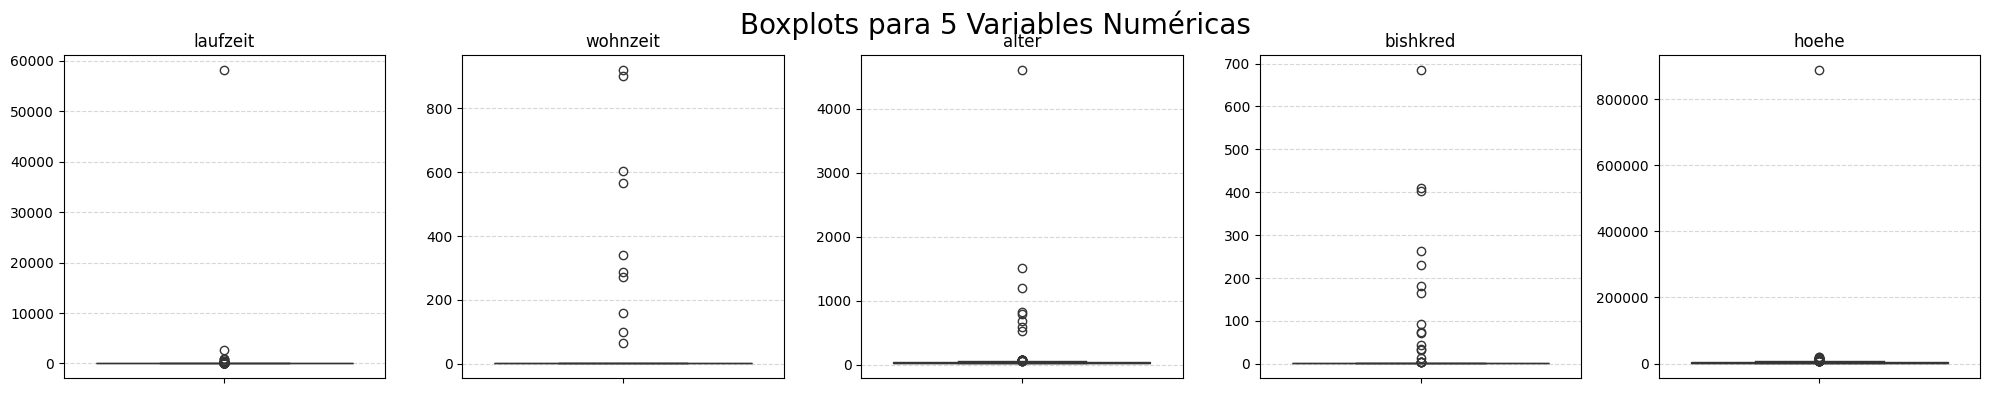

In [17]:
print("\n--- REVISIÓN DE PRESENCIA DE OUTLIERS VISUALMENTE ---")
## Seleccionamos solamente las columnas numéricas para la búsqueda de Outliers


## Éstas variables son numéricas, el resto, aunque parecen
lista_categoricos = ['laufzeit', 'wohnzeit', 'alter', 'bishkred', 'hoehe']


def plot_output(df: pd.DataFrame, listado: list) -> None:
    """
    Crea un gráfico de caja para una columna específica del DataFrame. Imprime los resultados


    Args:
        df (pd.DataFrame): El DataFrame a limpiar.
        listado (list): Listado de columnas numéricas sobre las cuales hacer la búsqueda de valores atípicos.

    Returns:
        None
    """
    df_numeric = df.select_dtypes(include=np.number)

    # Filtramos la lista de variables para trabajar solo con las que son numéricas
    variables = [var for var in lista_categoricos if var in df_numeric.columns]

    num_vars = len(variables)

    n_cols = 5
    n_rows = (num_vars + n_cols - 1) // n_cols

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, var in enumerate(variables):

        ax = plt.subplot(n_rows, n_cols, i + 1)

        sns.boxplot(y=df_numeric[var], ax=ax, color='#6B8E23') # Color Olive Drab

        ax.set_title(var, fontsize=12)
        ax.set_ylabel('') # Eliminar la etiqueta del eje Y para limpiar espacio
        ax.set_xlabel('') # Eliminar la etiqueta del eje X
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.suptitle(f"Boxplots para {num_vars} Variables Numéricas", fontsize=20, y=1.0)


## Función para la detección de Outliers
def detect_outliers_iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Identifica los valores en un DataFrame que son atípicos (outliers) según el
    cuartil. La salida es un DataFrame con los valores atípicos.

    Args:
        df (pd.DataFrame): El DataFrame a detectar valores atípicos.
          column (str): Columna sobre la cual se hará la detección de outliers.

    Returns:
        pd.DataFrame: El DataFrame con los valores atípicos.
    """

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definición de los límites de detección
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar los datos para encontrar outliers
    outliers = df[
        (df[column] < lower_bound) | (df[column] > upper_bound)
    ][column]

    return outliers



print("\n--- DETECCIÓN DE OUTLIERS (Método IQR) ---")
n = len(data_imputed)
outlier_count = 0
for var in lista_categoricos:
    outliers_df = detect_outliers_iqr(data_imputed, var)
    if not outliers_df.empty:
        print(f"[{var}]: {len(outliers_df)} outliers encontrados, { np.round(100 * len(outliers_df)/n, 2)} % del total ")
        outlier_count += len(outliers_df)

if outlier_count == 0:
    print("No se detectaron outliers en las variables seleccionadas.")

print("\n--- PLOT DE LOS VALORES ATÍPICOS ---")

plot_output(data_imputed, lista_categoricos)

print("------------------------------------------")


In [18]:
## Revisión de Ourliers

data_imputed['hoehe'][data_imputed['hoehe'] < 20000].describe()


count      980.000000
mean      3273.830612
std       2817.519263
min        250.000000
25%       1371.750000
50%       2324.000000
75%       3972.250000
max      18424.000000
Name: hoehe, dtype: float64

In [19]:
## y sí elimino todos los outliers sin mas?

def remove_outliers_iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:

    # 1. Calculate Quartiles (Q1, Q3) and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # 2. Define the outlier bounds (1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_final = df[
        (df[column] >= lower_bound) & (df[column] <= upper_bound)
    ]

    num_outliers = len(df) - len(df_final)
    if num_outliers > 0:
        print(f"   -> Outlier check on '{column}': {num_outliers} records removed.")
    else:
        print(f"   -> Outlier check on '{column}': No outliers found.")

    return df_final

In [20]:
## ¿Y sí eliminamos los Outliers, perdemos muchos datos? -- Esto es una prueba, hay que eliminarlo al final.
print(f'Original shape:{len(data_imputed)}')
df_test1 = remove_outliers_iqr(data_imputed, 'bishkred')
print(f'Original Eliminando outliers bishkred:{len(df_test1)}, ({np.round(100 * len(df_test1)/len(data_imputed), 2)}% del original)')

df_test2 = remove_outliers_iqr(df_test1, 'laufzeit')
print(f'Original Eliminando outliers laufzeit:{len(df_test2)}, ({np.round(100 * len(df_test2)/len(data_imputed), 2)}% del original)')

df_test3 = remove_outliers_iqr(df_test2, 'wohnzeit')
print(f'Original Eliminando outliers wohnzeit:{len(df_test3)}, ({np.round(100 * len(df_test3)/len(data_imputed), 2)}% del original)')

df_test4 = remove_outliers_iqr(df_test3, 'alter')
print(f'Original Eliminando outliers alter:{len(df_test4)}, ({np.round(100 * len(df_test4)/len(data_imputed), 2)}% del original)')

df_test5 = remove_outliers_iqr(df_test4, 'hoehe')
print(f'Original Eliminando outliers hoehe:{len(df_test5)}, ({np.round(100 * len(df_test5)/len(data_imputed), 2)}% del original)')

## Se eliminarían bastantes. ¿Habrá que imputar, o nos quedamos con el 81%?
## Opción 2: Ver si con una transformación puedo disminuir los outliers, con logaritmo.

Original shape:992
   -> Outlier check on 'bishkred': 39 records removed.
Original Eliminando outliers bishkred:953, (96.07% del original)
   -> Outlier check on 'laufzeit': 84 records removed.
Original Eliminando outliers laufzeit:869, (87.6% del original)
   -> Outlier check on 'wohnzeit': 25 records removed.
Original Eliminando outliers wohnzeit:844, (85.08% del original)
   -> Outlier check on 'alter': 35 records removed.
Original Eliminando outliers alter:809, (81.55% del original)
   -> Outlier check on 'hoehe': 69 records removed.
Original Eliminando outliers hoehe:740, (74.6% del original)


In [21]:
## Imputación de datos con la media

def impute_invalid_values_with_mode(df: pd.DataFrame, vars: list) -> pd.DataFrame:
    """
    Identifica los valores en un DataFrame que no están en la lista de valores válidos
    (definida en 'rules') y los reemplaza con la MODA (el valor más frecuente)
    de esa columna.

    Args:
        df (pd.DataFrame): El DataFrame a limpiar.
        vars (list): Lista de variables numéricas sobre las cuales deseamos hacer el proceso de imputación.

    Returns:
        pd.DataFrame: El DataFrame con los valores inconsistentes imputados.
    """
    # Creamos una copia para evitar modificar el DataFrame original
    df_imputed = df.copy()
    total_imputations = 0
    num_total = len(df_imputed)

    print(f"\n--- Iniciando Imputación de Consistencia Categórica (Usando la Media) ---")

    # Iteramos sobre el diccionario de reglas
    for col in vars:
        # Verificamos que la columna exista en el DataFrame
        if col in df_imputed.columns:

            outliers = detect_outliers_iqr(df_imputed, col)
            outlier_indices = outliers.index

            # Creamos la mascara para identificar los datos que NO son atípicos.
            inlier_mask = ~df_imputed.index.isin(outlier_indices)

            # Reemplazar los valores en el DataFrame completo.
            # Usamos los índices de los outliers para asignar la media calculada.
            num_imputed = len(outlier_indices)

            if num_imputed > 0:
                # Calcular la media de la columna solo en los datos NO atípicos.
                unbiased_mean = df_imputed.loc[inlier_mask, col].mean()

                ## Sí hay algún error, mandar los datos sin modificar
                if pd.isna(unbiased_mean):
                  print(f"Advertencia: La media no pudo calcularse para la columna '{col}'. No se realizó la imputación.")
                  return df_imputed
                else:
                  # En caso contrario, llenar con la media sin sesgo
                  df_imputed.loc[outlier_indices, col] = unbiased_mean
                  total_imputations += num_imputed
                  print(f"   - Columna '{col}': {num_imputed} valores imputados con la media ({unbiased_mean}). Modificaciones por renglón: {np.round(100 * (num_imputed/num_total), 2)}%")
            else:
                print(f"   - Columna '{col}': No se encontraron valores atípicos para imputar.")
                return df_imputed

    print(f"Total general de valores imputados: {total_imputations}")

    return df_imputed
    print(f"Total general de valores imputados: {total_imputations}")
    print("-" * 40)


-----  Realizamos la imputación de Outliers ------

--- Iniciando Imputación de Consistencia Categórica (Usando la Media) ---
   - Columna 'laufzeit': 78 valores imputados con la media (18.674418604651162). Modificaciones por renglón: 7.86%
   - Columna 'wohnzeit': 10 valores imputados con la media (2.8569948186528498). Modificaciones por renglón: 1.01%
   - Columna 'alter': 30 valores imputados con la media (34.96631578947368). Modificaciones por renglón: 3.02%
   - Columna 'bishkred': 19 valores imputados con la media (1.3903462749213011). Modificaciones por renglón: 1.92%
   - Columna 'hoehe': 74 valores imputados con la media (2670.0). Modificaciones por renglón: 7.46%
Total general de valores imputados: 211

--- PLOT DE LOS VALORES ATÍPICOS ---


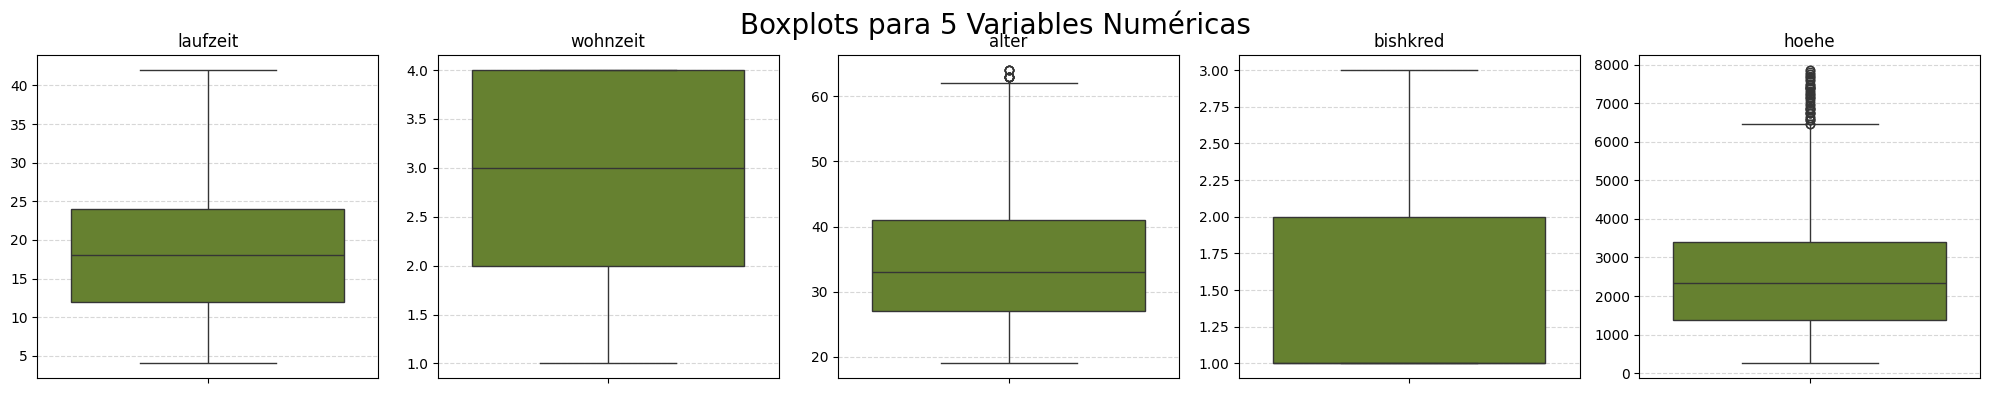

In [22]:
lista_categoricos = ['laufzeit', 'wohnzeit', 'alter', 'bishkred', 'hoehe']
print('-----  Realizamos la imputación de Outliers ------')
data_imputed_out = impute_invalid_values_with_mode(data_imputed, lista_categoricos)

print("\n--- PLOT DE LOS VALORES ATÍPICOS ---")

plot_output(data_imputed_out, lista_categoricos)

In [23]:
# Como el pipeline ya hace la imputación de datos, vamos a partir del data_clean

# Plot de variables numéricas
def plot_descriptivo(df: pd.DataFrame, lista_paper_num: list, lista_paper_cat: list, lista_paper_ord: list) -> None:
  """
  Genera gráficos de las variables diferenciados por el tipo de variable a tratar.

  Args.
    df (pd.DataFrame): El DataFrame a limpiar.
    lista_paper_num (list): Lista de variables numéricas.
    lista_paper_cat (list): Lista de variables nominales & binarias.
    lista_paper_ord (list): Lista de variables ordinales.

    Returns:
    None
  """

  # Generación de Boxplots
  fig, axes = plt.subplots(1, 3, figsize = (35, 10))
  plt.subplots_adjust(wspace = 0.1)
  axes = axes.ravel()
  for col, ax in zip(df[lista_paper_num], axes):
      sns.boxplot(x = df[col], ax = ax, color='paleturquoise')
      ax.set(title = f'{col}', xlabel = None)
  plt.show()


  fig, axes = plt.subplots(2, 3, figsize = (35,15))
  fig.suptitle('Histograma de variables ordinales', fontsize = 20, y = 1)

  plt.subplots_adjust(wspace = 0.4)
  axes = axes.ravel()

  for col, ax in zip(df[lista_paper_ord], axes):
      sns.histplot(x = df[col], ax = ax, color='sandybrown', edgecolor='saddlebrown')
      ax.set(title = f'{col}', xlabel = None)

  plt.show()


  fig, axes = plt.subplots(2, 6, figsize = (35,15))
  fig.suptitle('Histograma de variables binarias y nominales', fontsize = 20, y = 1)
  plt.subplots_adjust(wspace = 0.4, hspace = 0.5)
  axes = axes.ravel()

  for col, ax in zip(df[lista_paper_cat], axes):
      sns.histplot(x = df[col], ax = ax,  color='yellowgreen', edgecolor='darkolivegreen')
      ax.set(title = f'{col}', xlabel = None)
      ax.tick_params(axis='x', labelrotation=45)
  plt.xticks(rotation=45)
  plt.show()



In [24]:
data_imputed_out.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,992.000000,981.000000,992.000000,992.000000,982.000000,992.000000,992.000000,992.000000,992.000000,992.000000,...,992.000000,980.000000,992.000000,992.000000,972.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,2.625000,18.674419,2.531250,2.832661,2670.000000,2.084677,3.385081,3.002016,2.690524,1.140121,...,2.381048,34.966316,2.681452,1.935484,1.390346,2.919355,1.846774,1.393145,1.962702,0.694556
std,1.259675,8.767652,1.068318,2.690234,1702.135861,1.573265,1.199100,1.120399,0.703165,0.470656,...,1.045853,10.238869,0.699819,0.529523,0.533908,0.641287,0.360387,0.488695,0.189588,0.460827
min,1.000000,4.000000,0.000000,0.000000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.000000,1.000000,1372.500000,1.000000,3.000000,2.000000,2.000000,1.000000,...,1.000000,27.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.000000,2.000000,2325.500000,1.000000,3.000000,3.000000,3.000000,1.000000,...,2.000000,33.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.000000,3.000000,3410.250000,3.000000,5.000000,4.000000,3.000000,1.000000,...,3.000000,41.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,42.000000,4.000000,10.000000,7865.000000,5.000000,5.000000,4.000000,4.000000,3.000000,...,4.000000,64.000000,3.000000,3.000000,3.000000,4.000000,2.000000,2.000000,2.000000,1.000000


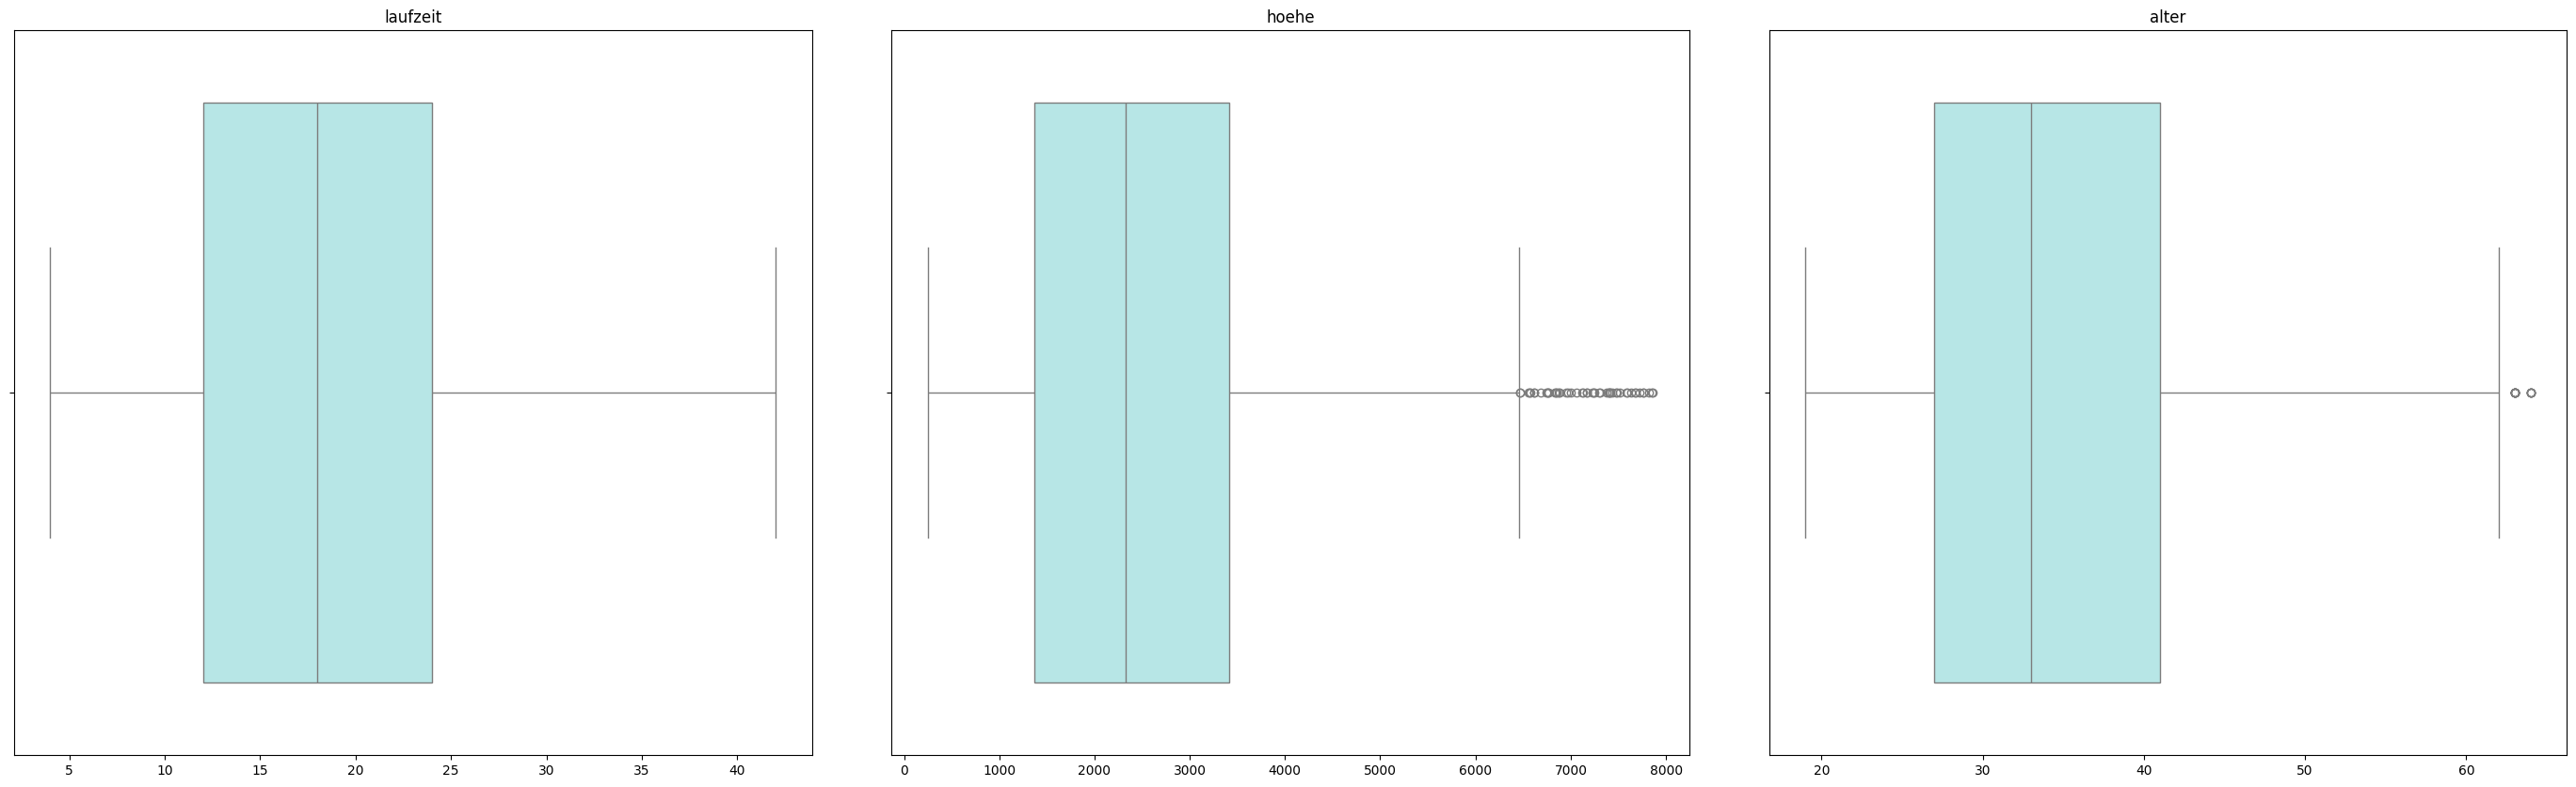

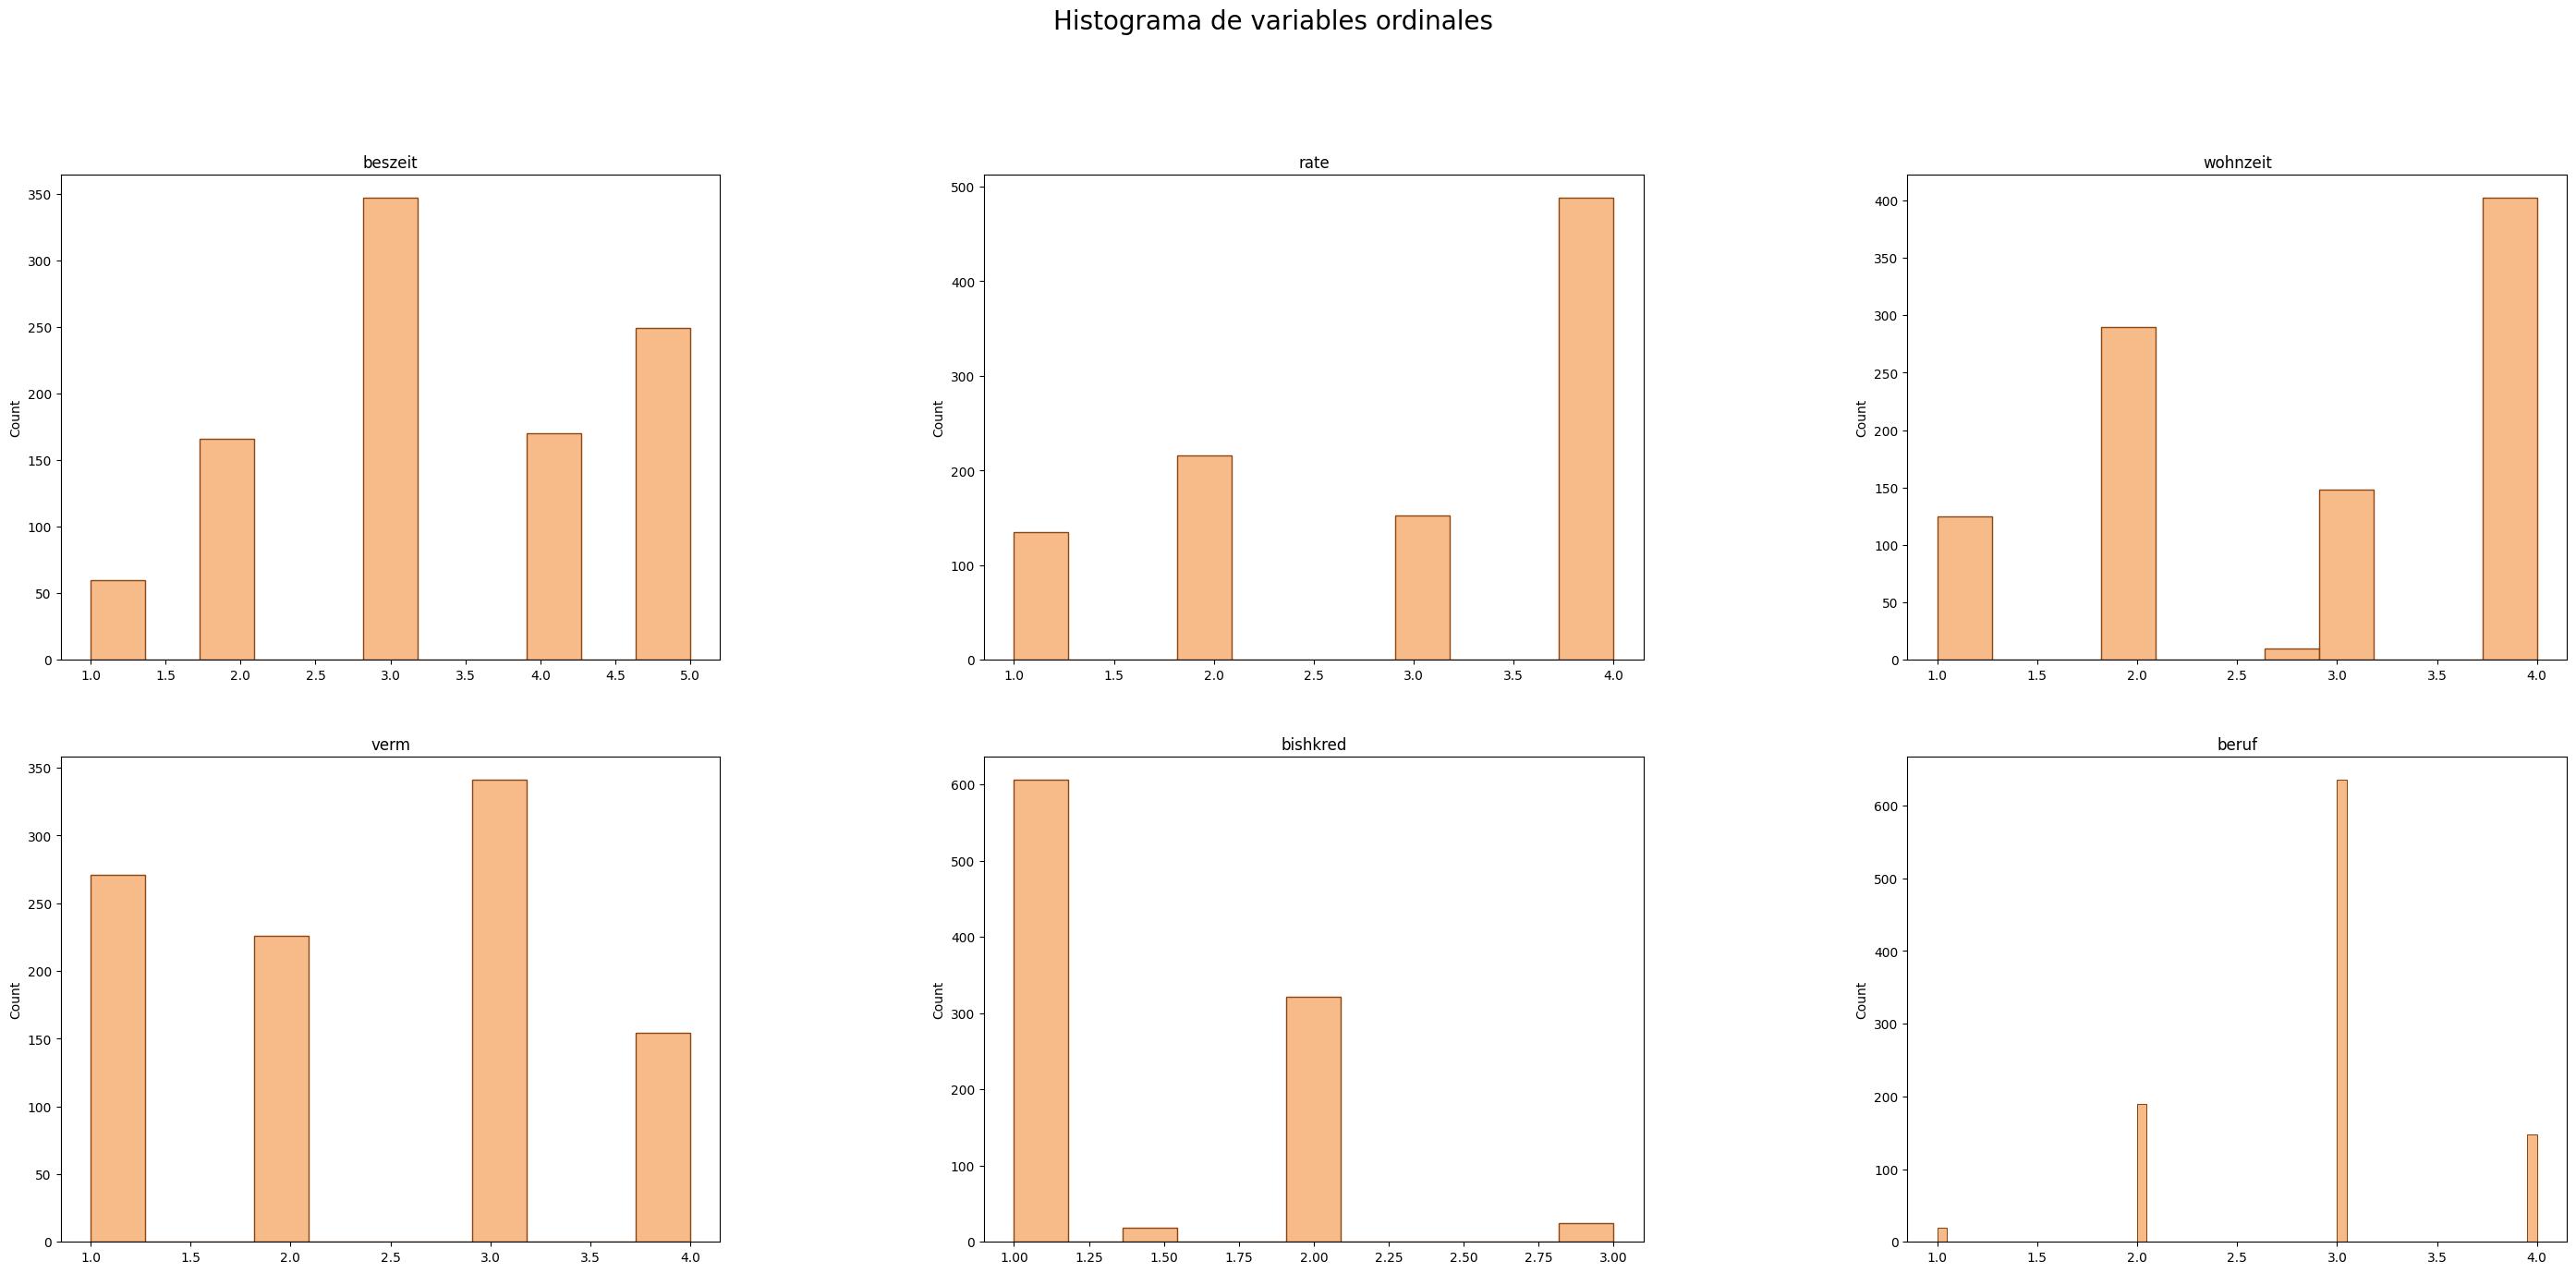

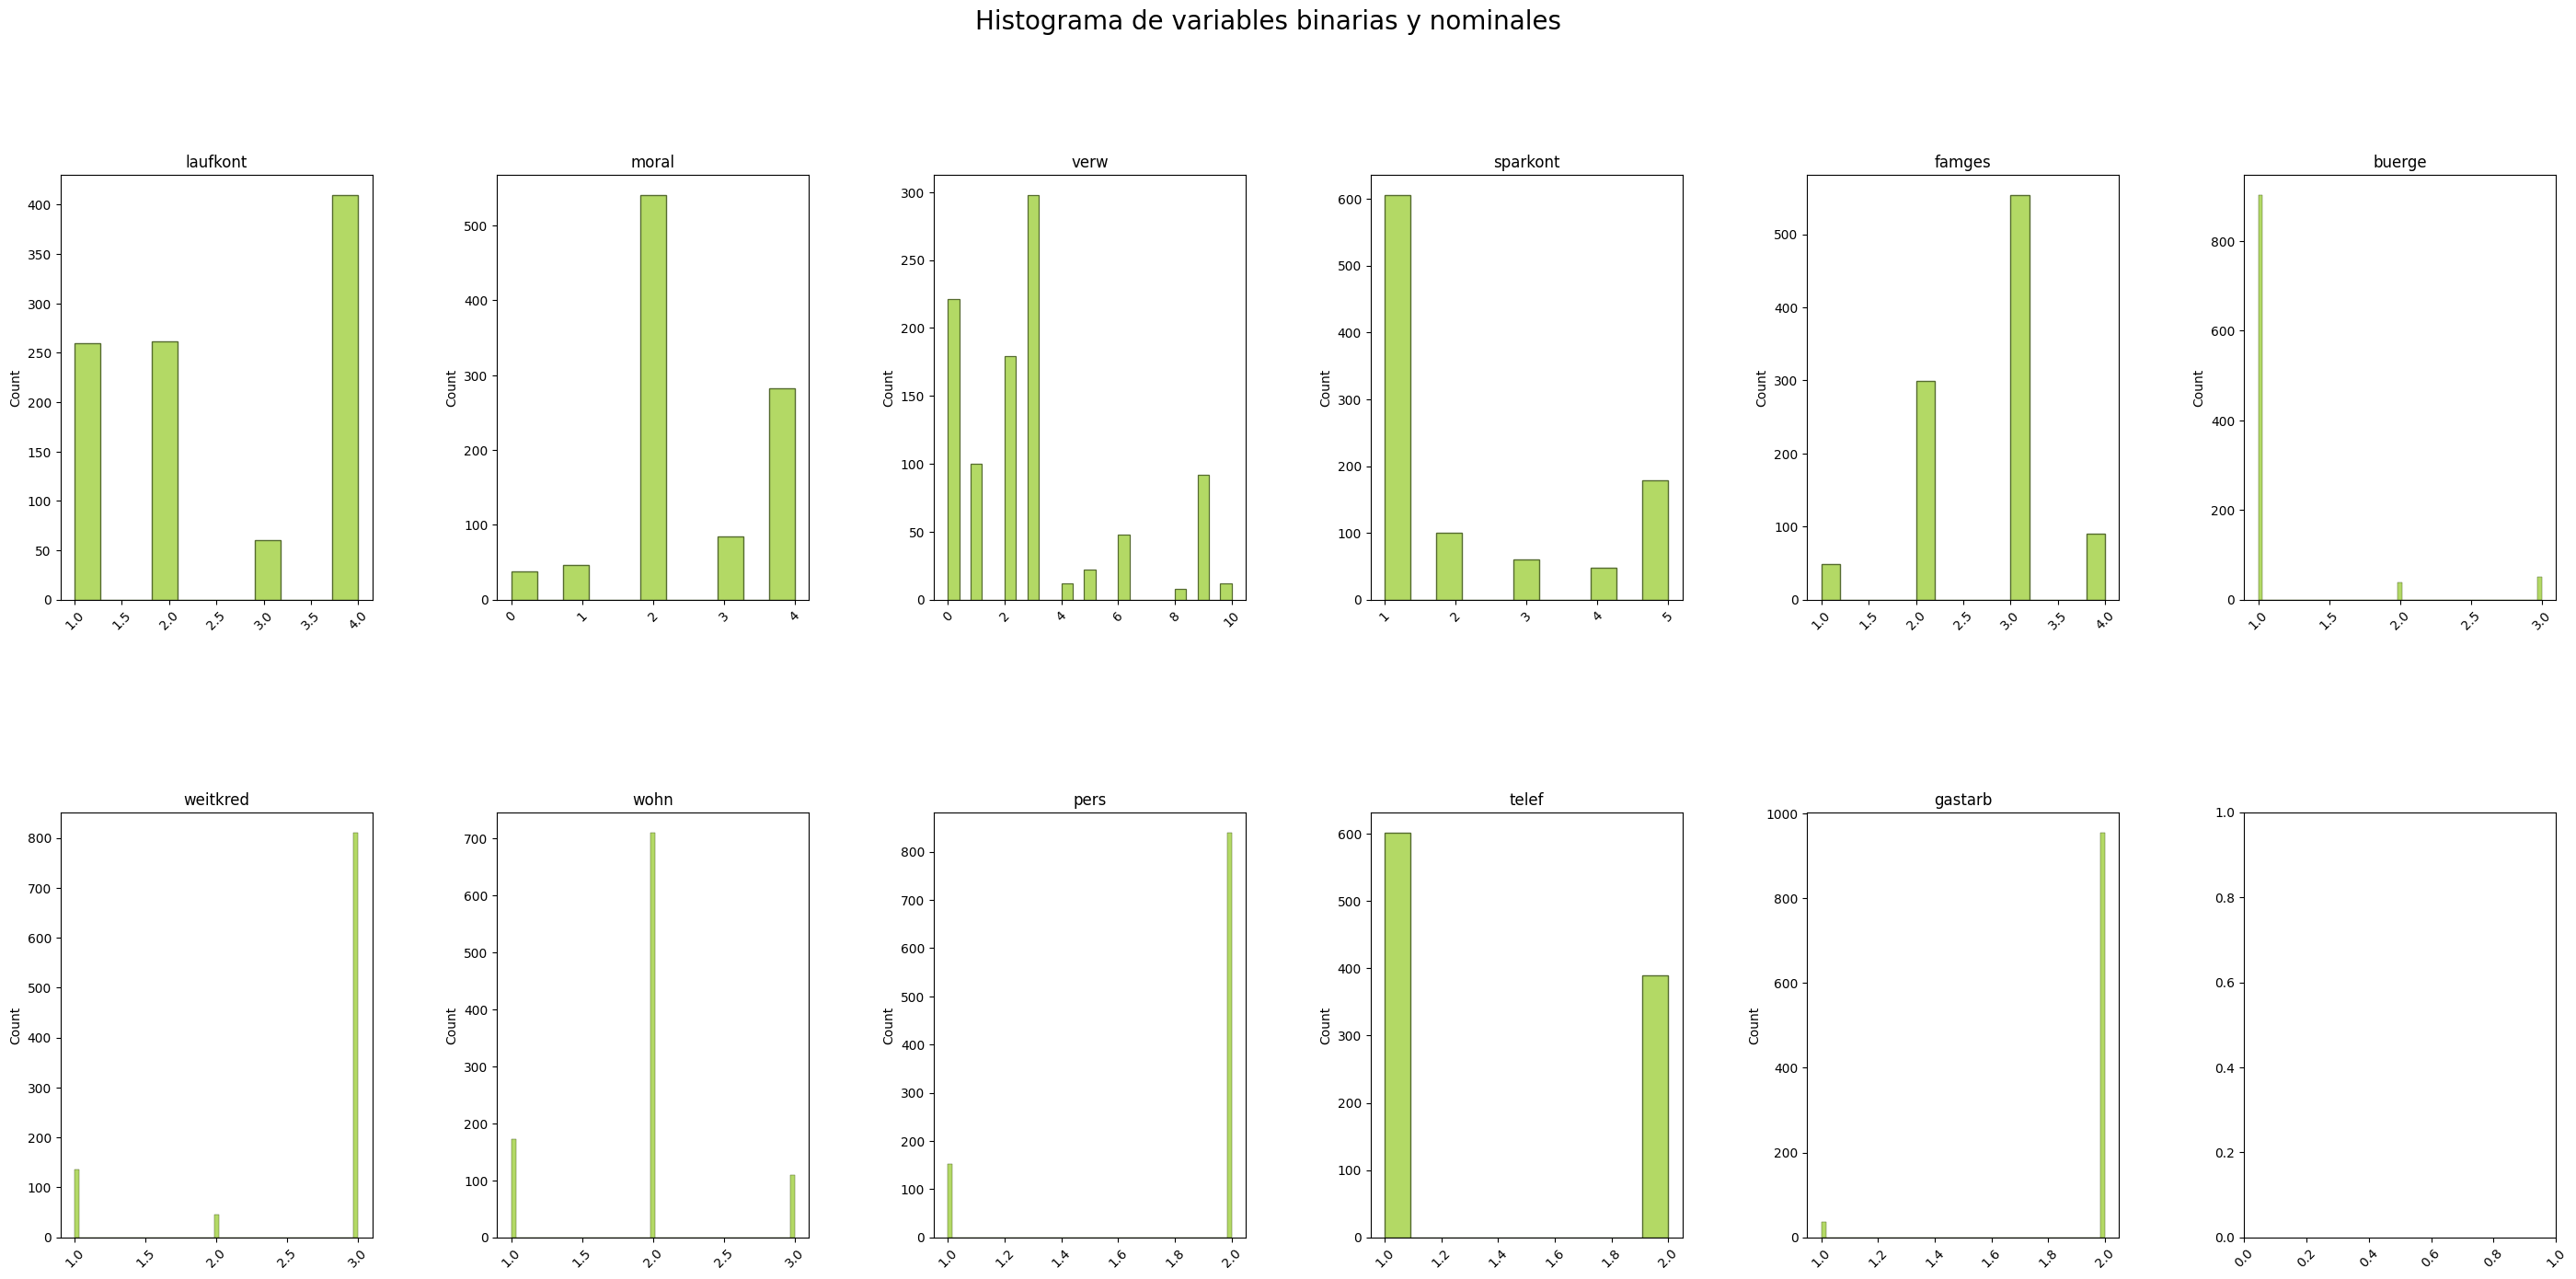

In [25]:
plot_descriptivo(data_imputed_out, lista_paper_num, lista_paper_cat, lista_paper_ord)

# **4. Preparación de los datos para el entrenamiento del modelo**


Generación del pipeline para la transformación de los datos, en preparación para el entrenamiento del modelo.

* **Datos categóricos:** Aplicación de One Hot Enconder
* **Datos numéricos:** Estandarización de datos
* **Datos binarios:** Transformación de las categorías a 1 y 0.


 **`NOTA PARA EL EQUIPO:`**  *En éste pipeline ya se contempla la imputación de Outliers, pero lo dejo porque podemos tomar un ambos códigos para generar versionamiento de los datos.*

In [26]:

# --- 1. Definición de Nombres de Columnas ---

# Variables Numéricas
numericas_pipe_nombres = ['laufzeit', 'hoehe', 'alter']

# Variables Categóricas-Nominales (que requieren One-Hot Encoding)
nominales_pipe_nombres = [
    'laufkont', # (status - categorical)
    'moral',    # (credit_history - categorical)
    'verw',     # (purpose - categorical)
    'sparkont', # (savings - categorical)
    'famges',   # (personal_status_sex - categorical)
    'buerge',   # (other_debtors - categorical)
    'weitkred', # (other_installment_plans - categorical)
    'wohn',     # (housing - categorical)
    'pers',     # (people_liable - binary)
    'telef',    # (telephone - binary)
    'gastarb'   # (foreign_worker - binary)
]

# Variables Categóricas-Ordinales (que requieren Ordinal Encoding)
ordinales_pipe_nombres = [
    'beszeit',  # (employment_duration - ordinal)
    'rate',     # (installment_rate - ordinal)
    'wohnzeit', # (present_residence - ordinal)
    'verm',     # (property - ordinal)
    'bishkred', # (number_credits - ordinal)
    'beruf'     # (job - ordinal)
]


In [27]:
## PIPELINE DE TRANSFORMACIÓN DE LOS DATOS (ÉSTA VERSIÓN SE PUEDE APLICAR SI DECIDIMOS ELIMINAR NULOS)

# Variables numéricas:
numericas_pipe = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])

# Variables categóricas-Nominales:
nominales_pipe = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Variables categóricas-ordinales:
ordinales_pipe = Pipeline(steps = [('impOrd', SimpleImputer(strategy='most_frequent')),
                                ('ordtrasnf', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])

# Conjuntas las transformaciones de todo tipo de variable y
# deja sin procesar aquellas que hayas decidido no transformar:

columnasTransformer = ColumnTransformer(transformers = [('numpipe', numericas_pipe, numericas_pipe_nombres),
                                                        ('nominals', nominales_pipe, nominales_pipe_nombres),
                                                        ('ordinales', ordinales_pipe, ordinales_pipe_nombres)],
                                        remainder='passthrough')

In [28]:
## PIPELINE DE TRANSFORMACIÓN DE LOS DATOS (ÉSTA VERSIÓN SE PUEDE APLICAR SI DECIDIMOS IMPUTAR NULOS)

# --- 2. Definición de Pipelines Individuales (con Imputación) ---

# Pipeline para Variables Numéricas: Imputación con Mediana + Escalado MinMax
numericas_pipe = Pipeline(steps = [
    ('impMediana', SimpleImputer(strategy='median')),
    ('escalaNum', MinMaxScaler(feature_range=(1,2)))
])

# Pipeline para Variables Nominales: Imputación con Moda + One-Hot Encoding
nominales_pipe = Pipeline(steps = [
    ('impModa', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Pipeline para Variables Ordinales: Imputación con Moda + Ordinal Encoding
ordinales_pipe = Pipeline(steps = [
    ('impOrd', SimpleImputer(strategy='most_frequent')),
    ('ordtrasnf', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


# --- 3. Combinación de Pipelines con ColumnTransformer ---

data_preprocessor = ColumnTransformer(
    transformers=[
        # Aplica la pipeline numérica a las columnas numéricas
        ('num', numericas_pipe, numericas_pipe_nombres),
        # Aplica la pipeline nominal a las columnas nominales
        ('nom', nominales_pipe, nominales_pipe_nombres),
        # Aplica la pipeline ordinal a las columnas ordinales
        ('ord', ordinales_pipe, ordinales_pipe_nombres)
    ],
    remainder='passthrough', # Mantener columnas que no estén en la lista (si las hay)
    verbose_feature_names_out=False # Simplifica los nombres de las features de salida
).set_output(transform="pandas")


# --- 4. Función de Preprocesamiento Principal ---

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica el ColumnTransformer completo al DataFrame, realizando la imputación,
    escalado y codificación necesarios para la implementación del modelo.

    Args:
        df (pd.DataFrame): El DataFrame con las variables a preprocesar.

    Returns:
        pd.DataFrame: El DataFrame transformado (o None si hay un error).
    """
    print("\n--- Iniciando Preprocesamiento de Datos ---")

    try:
        # Ajusta y transforma los datos
        # Nota: Si ya tienes un transformador ajustado (fit), usa solo .transform(df)
        df_processed = data_preprocessor.fit_transform(df)

        print("Preprocesamiento completado. Datos listos para el modelo.")
        print(f"Shape de los datos transformados: {df_processed.shape}")

        return df_processed

    except Exception as e:
        print(f"Error durante el preprocesamiento: {e}")
        return None

**División de la base entre entrenamiento y validación**

* Variable objetivo (y): 'kredit'
* El análisis muestra que hay un desbalanceo significativo entre las clases, pues la proporción de datos es 70:30, con lo cual podemos considerar que hay una diferencia considerable entre las clases de buenos y malos en el conjunto de datos.

Éste desequilibrio puede afectar al rendimiento de los modelos de clasificación que podamos plantear, especialmente para el caso de la clase minoritaria. Para tratar de lidear con el problema, a lo largo del ejercicio se plantearán alternativas como el sobreajuste y subajuste, que nos apoyará a equilibrar el conjunto de datos, dándo mayor representación a la clase minoritatía y apoyando al desempeño del modelo.

In [29]:
data_clean['kredit'].value_counts(normalize = True)

kredit
1.0    0.694556
0.0    0.305444
Name: proportion, dtype: float64

In [44]:
def split_data_by_target(df: pd.DataFrame, target_column_name: str):
    """
    Divide un DataFrame en dos partes:
    X (variables predictoras/features) y y (variable objetivo/target).

    Args:
        df (pd.DataFrame): El DataFrame completo que contiene features y target.
        target_column_name (str): El nombre de la columna que será la variable 'y'.

    Returns:
        tuple: Una tupla que contiene (X, y), donde X es un DataFrame y y es una Serie.
               Devuelve (None, None) si la columna target no existe.
    """
    # Verificar si la columna target existe en el DataFrame
    if target_column_name not in df.columns:
        print(f"Error: La columna objetivo '{target_column_name}' no se encontró en el DataFrame.")
        return None, None

    # Definir la variable objetivo (y)
    y = df[target_column_name].copy()

    # Definir las variables predictoras (X)
    X = df.drop(columns=[target_column_name], axis=1).copy()

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify= y, random_state=1234) # La semilla garantiza que nuestro código sea reproducible

    print(f"División de datos completada.")
    print(f"   - X Train (Features): {Xtrain.shape[0]} filas, {Xtrain.shape[1]} columnas.")
    print(f"   - X Test (Features): {Xtest.shape[0]} filas, {Xtest.shape[1]} columnas.")
    print(f"   - y Train (Target '{target_column_name}'): {ytrain.shape[0]} filas.")
    print(f"   - y Test (Target '{target_column_name}'): {ytest.shape[0]} filas.")

    return Xtrain, Xtest, ytrain, ytest


In [45]:
# DE MOMENTO ELIMINAMOS LA COLUMNA DESCONOCIDA *pendiente: hay que ver qué hacer con ella*

data_clean = data_imputed_out.drop('mixed_type_col', axis=1)

In [46]:
## Ejecución del código para dividir entre train y test

Xtrain, Xtest, ytrain, ytest = split_data_by_target(data_clean, 'kredit')

División de datos completada.
   - X Train (Features): 694 filas, 20 columnas.
   - X Test (Features): 298 filas, 20 columnas.
   - y Train (Target 'kredit'): 694 filas.
   - y Test (Target 'kredit'): 298 filas.


In [47]:
## Ejecutamos la transformación con el conjunto de entrenamiento

Xtmp = Xtrain.copy()
tmp = columnasTransformer.fit_transform(Xtmp)
print("Dimensión de los datos de entrada:")
print("antes de aplicar las transformaciones:", Xtmp.shape)

print("después de aplicar las transformaciones:", tmp.shape)

Dimensión de los datos de entrada:
antes de aplicar las transformaciones: (694, 20)
después de aplicar las transformaciones: (694, 41)


In [48]:
# Una vez ejecutada la transformación, y como se va a utilizar Validación-Cruzada, concatena los conjuntos de entrenamiento
# y prueba en uno nuevo conjunto aumentado que llamaremos trainval:

Xtraintest = pd.concat([Xtrain, Xtest], axis=0)
ytraintest = pd.concat([ytrain, ytest], axis=0)

# Veamos cuántas variables nuevas se introducen con las transformaciones One-Hot-Encoding:
Xtmp = Xtraintest.copy()
tmp = columnasTransformer.fit_transform(Xtmp)
print("Dimensión de las variables de entrada ANTES de las transformaciones:", Xtmp.shape)
print("Dimensión de las variables de entrada DESPUÉS de las transformaciones:", tmp.shape)

Dimensión de las variables de entrada ANTES de las transformaciones: (992, 20)
Dimensión de las variables de entrada DESPUÉS de las transformaciones: (992, 41)


# **5. Entrenamiento del modelo**

Plantearemos un modelo de clasificación, en donde la variable objetivo a predecir será `kcredit`, es decir, el indicador de que el crédito haya sido bueno o malo. Para ello, trataremos de predecirlo en función al resto de las variables (features). Probando distintos modelos de clasificación. Se propone considerar los siguientes puntos:

* **1.** Generar un Cross-validation, pues se tienen relativamente pocos datos.

* **2.** Usar el versionamiento para explorar la mejor elección de hiperparámetros.

**`NOTA AL EQUIPO`** Los distintos modelos que apliquemos los podemos incluir en el versionamiento, igual.


In [35]:
# Definimos una función que evaluará cada modelo con diferentes tipos de métricas,
# así como incluyendo algún método de submuestreo o sobremuestreo.

!pip install imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def mi_fun(modelo, nombre, Xtraintest, ytraintest, metodo_uo=None):
        """
        Se lleva a cabo el proceso de entrenamiento y evaluación
        con diferentes métricas.
        Args:
             modelo: modelo con la configuración deseada
             nombre: nombre del modelo
             Xtriantest, ytraintest: Variables de entrada y variable de salida
             mod_uo: método de submuestreo o sobremuestreo, si aplica.
        """
                # ImbPipeline
        pipeline = ImbPipeline(steps=[
            ('preprocesamiento', columnasTransformer), # Agregamos la modificación que nos notificó el profesor por correo
            ('sub_sobre_muestreo', metodo_uo),
            ('model', modelo)
        ])

        micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)
        mismetricas = {
            'miaccuracy': 'accuracy',
            'miprecision': 'precision',
            'mirecall': 'recall',
            'mifi': 'f1',
            'miauc': 'roc_auc',
            'migmean': make_scorer(geometric_mean_score)
        }

        scores = cross_validate(pipeline, Xtraintest, np.ravel(ytraintest), scoring=mismetricas, cv=micv, return_train_score=True)

        print('>> %s' % nombre)
        for j, k in enumerate(list(scores.keys())):
            if j > 1:
                print('\t %s %.4f (%.3f)' % (k, np.nanmean(scores[k]), np.nanstd(scores[k])))

"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [36]:
nombre = "Regresión_Logística"

# Selecciona la configuración de valores de hiperparámetros que consideres
# te da el mejor desempeño:
modelo = LogisticRegression(penalty='l2',
                            solver='newton-cg',
                            max_iter=1000,
                            C=1,
                            random_state=1)

# Selecciona el método de submuestreo o sobremuestreo, si lo deseas incluir.
#metodo_uo= SMOTE(random_state=42)
metodo_uo = BorderlineSMOTE(random_state=42, k_neighbors=5, m_neighbors=10)
# *********** Aquí termina la sección de agregar código *************


# Evaluemos la configuración seleccionada:
mi_fun(modelo,nombre, Xtraintest, ytraintest, metodo_uo)

>> Regresión_Logística
	 test_miaccuracy 0.7110 (0.030)
	 train_miaccuracy 0.7390 (0.011)
	 test_miprecision 0.8403 (0.020)
	 train_miprecision 0.8650 (0.006)
	 test_mirecall 0.7209 (0.035)
	 train_mirecall 0.7396 (0.014)
	 test_mifi 0.7757 (0.027)
	 train_mifi 0.7974 (0.010)
	 test_miauc 0.7676 (0.023)
	 train_miauc 0.8147 (0.006)
	 test_migmean 0.7043 (0.030)
	 train_migmean 0.7386 (0.010)


In [37]:
nombre = 'DecisionTree-DT'
modelo = DecisionTreeClassifier(max_depth = 3,
                                        min_samples_split=20,
                                        #min_samples_leaf=1,
                                        random_state= 123
                                      )

metodo_uo = SMOTE(random_state = 123)

# *********** Aquí termina la sección de agregar código *************


# Evaluemos la configuración seleccionada:
mi_fun(modelo, nombre, Xtraintest, ytraintest, metodo_uo)

>> DecisionTree-DT
	 test_miaccuracy 0.6559 (0.033)
	 train_miaccuracy 0.6869 (0.016)
	 test_miprecision 0.8246 (0.032)
	 train_miprecision 0.8537 (0.022)
	 test_mirecall 0.6439 (0.065)
	 train_mirecall 0.6652 (0.051)
	 test_mifi 0.7206 (0.036)
	 train_mifi 0.7459 (0.024)
	 test_miauc 0.7045 (0.028)
	 train_miauc 0.7400 (0.009)
	 test_migmean 0.6592 (0.037)
	 train_migmean 0.6973 (0.012)


In [38]:
nombre = 'Random Forest'
modelo = RandomForestClassifier(n_estimators= 200,
                                        max_depth= 3,
                                        min_samples_split= 50,
                                        random_state=123)

metodo_uo = SMOTE(random_state = 123)

# *********** Aquí termina la sección de agregar código *************


# Evaluemos la configuración seleccionada:
mi_fun(modelo, nombre, Xtraintest, ytraintest, metodo_uo)


>> Random Forest
	 test_miaccuracy 0.6942 (0.032)
	 train_miaccuracy 0.7288 (0.011)
	 test_miprecision 0.8199 (0.018)
	 train_miprecision 0.8508 (0.006)
	 test_mirecall 0.7175 (0.046)
	 train_mirecall 0.7392 (0.017)
	 test_mifi 0.7645 (0.029)
	 train_mifi 0.7910 (0.011)
	 test_miauc 0.7551 (0.027)
	 train_miauc 0.8052 (0.008)
	 test_migmean 0.6774 (0.028)
	 train_migmean 0.7219 (0.009)


In [39]:
nombre = 'XGBoosting'
modelo = XGBClassifier(booster= 'gbtree',
                               n_estimators=100,
                               max_depth= 3,
                               learning_rate=0.01,
                               subsample=0.7,
                               random_state=5,
                               #objective='binary:logistic',
                               n_jobs=-1)
metodo_uo = SMOTE(random_state = 123)

# *********** Aquí termina la sección de agregar código *************

# Evaluemos la configuración seleccionada:
mi_fun(modelo, nombre, Xtraintest, ytraintest, metodo_uo)

>> XGBoosting
	 test_miaccuracy 0.6754 (0.033)
	 train_miaccuracy 0.7185 (0.009)
	 test_miprecision 0.8280 (0.024)
	 train_miprecision 0.8672 (0.011)
	 test_mirecall 0.6725 (0.040)
	 train_mirecall 0.7026 (0.018)
	 test_mifi 0.7416 (0.030)
	 train_mifi 0.7760 (0.009)
	 test_miauc 0.7458 (0.030)
	 train_miauc 0.8055 (0.006)
	 test_migmean 0.6765 (0.034)
	 train_migmean 0.7279 (0.010)


# **6. Explicabilidad del modelo**


### SHAP XGBoost

Tras evaluar distintos algoritmos de clasificación, se seleccionó **XGBoost** como modelo principal por su **rendimiento superior y estabilidad** en las métricas de evaluación (ROC-AUC y PR-AUC), especialmente ante el desbalance de clases propio del problema de riesgo crediticio. 

A diferencia de modelos lineales como la regresión logística o de ensamblado como Random Forest, **XGBoost** combina árboles de decisión secuenciales con un esquema de *boosting* que minimiza errores residuales en cada iteración, optimizando el sesgo y la varianza del modelo.

Este enfoque permite capturar relaciones **no lineales** y **complejas interacciones entre variables** (por ejemplo, entre historial crediticio, monto del préstamo y duración), proporcionando predicciones más precisas y consistentes. Además, su compatibilidad con **SHAP** facilita la interpretabilidad del modelo, permitiendo explicar tanto la influencia global de las variables como las razones detrás de decisiones individuales. 


Usando preprocesador: columnasTransformer


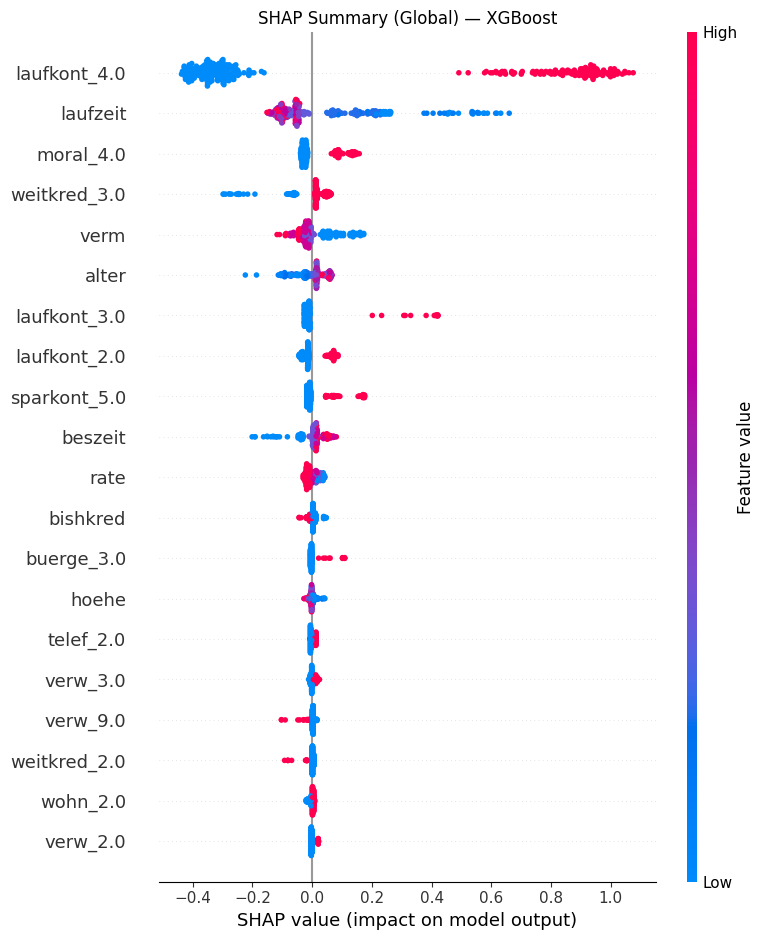

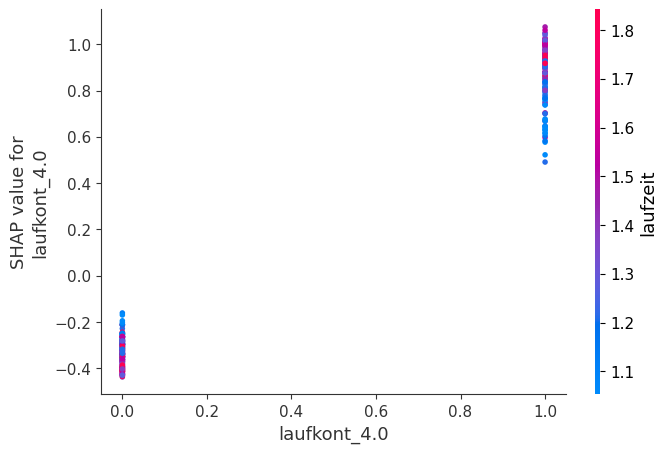

In [50]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

# 1) Toma el preprocesador que ya existe en tu notebook
pre = None
for name in ["columnasTransformer", "data_preprocessor", "pre", "preprocessor"]:
    if name in globals() and isinstance(globals()[name], ColumnTransformer):
        pre = globals()[name]
        print(f"Usando preprocesador: {name}")
        break
if pre is None:
    raise RuntimeError("No encontré tu ColumnTransformer. Ajusta el nombre en la lista de arriba.")

# 2) Construye el mismo pipeline que usas en evaluación: pre -> SMOTE -> modelo
pipe_shap = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", metodo_uo),     # SMOTE solo actúa al entrenar
    ("model", modelo)
])

# 3) Entrena el pipeline sobre tu set de entrenamiento (el que usaste en mi_fun)
pipe_shap.fit(Xtraintest, ytraintest)

# 4) Prepara nombres de features después del preprocesamiento (para plots legibles)
def get_feature_names_from_ct(ct, input_df: pd.DataFrame):
    out = []
    for name, transformer, cols in ct.transformers_:
        if transformer == "drop": 
            continue
        if transformer == "passthrough":
            if isinstance(cols, slice): cols = input_df.columns[cols]
            out.extend(list(cols)); 
            continue
        try:
            if hasattr(transformer, "get_feature_names_out"):
                names = transformer.get_feature_names_out(cols)
            elif hasattr(transformer, "named_steps"):
                last = list(transformer.named_steps.values())[-1]
                names = last.get_feature_names_out(cols) if hasattr(last,"get_feature_names_out") else np.array(cols)
            else:
                names = np.array(cols)
        except Exception:
            names = np.array(cols)
        out.extend([str(n) for n in names])
    return out

def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

if isinstance(Xtraintest, pd.DataFrame):
    feature_names = get_feature_names_from_ct(pre, Xtraintest)
else:
    feature_names = None  # caemos a índices numéricos

# 5) Para explicar, usamos X ya preprocesado (¡sin SMOTE en inferencia!)
Xpre = to_dense(pre.transform(Xtraintest))

# 6) TreeExplainer para XGBoost
shap.initjs()
explainer = shap.TreeExplainer(pipe_shap.named_steps["model"])

# submuestrea para velocidad (ajusta si quieres)
n_bg = min(300, Xpre.shape[0])
idx = np.random.choice(Xpre.shape[0], size=n_bg, replace=False)
Xbg = Xpre[idx]

# 7) Valores SHAP (global)
sv = explainer.shap_values(Xbg)

plt.figure(figsize=(9,5))
shap.summary_plot(sv, Xbg, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Global) — XGBoost")
plt.tight_layout(); plt.show()

# 8) Dependence plot de la feature más influyente
importances = np.abs(sv).mean(axis=0)
top_idx = int(np.argsort(importances)[-1])
top_feat = (feature_names[top_idx] if feature_names else f"f_{top_idx}")
shap.dependence_plot(top_feat, sv, Xbg, feature_names=feature_names, show=True)

# 9) Explicación local (una observación)
x_local = Xpre[0:1]
sv_local = explainer.shap_values(x_local)
shap.force_plot(explainer.expected_value, sv_local, x_local, feature_names=feature_names)
